## Small network with complex plasticity rule (flexible mode only)
*NOTE: For several functions, variants can be tested by uncommenting commented lines.*

#### Import Brian 2 and Matplotlib

In [1]:
from brian2 import *
import brian2 as b2
print(f"Brian version: {b2.__version__}")
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

Brian version: 2.7.1


#### Import Brian2Lava and set device (if desired)

In [2]:
device = "lava" # can be "lava", "cpp_standalone", "runtime", etc.
# Using Brian2Lava
if device == "lava":
    # Import Brian2Lava
    import brian2lava
    print(f"Brian2Lava version: {brian2lava.__version__}")

    # Set device
    set_device('lava', mode='flexible', hardware='CPU')
# Using other Brian device
else:
    set_device(device)

Brian2Lava version: 1.0.0b2


#### Set parameters

In [3]:
# General parameters
N          = 10         # number of neurons
delta_t    = 0.5*ms     # duration of one timestep
t_max      = 200*ms     # total duration of the simulation

# Neuron and static synapse parameters (values from https://doi.org/10.1007/s12559-022-10021-7)
tau_mem    = 10*ms                   # membrane time constant
tau_syn    = 5*ms                    # synaptic time constant
v_rev      = -65.0*mV                # intial/reversal membrane potential
v_rs       = -70*mV                  # reset potential
v_th       = -55.0*mV                # threshold potential
R_mem      = 10*Mohm                 # membrane resistance
t_ax_delay = 3.0*ms                  # axonal delay constant
t_ref      = 2*ms                    # refractory time
# j_0        = 0.15*namp               # mean of input current
# sigma_wn   = 0.05*namp*second**(1/2) # standard deviation of input current
j_0        = 0*namp                  # mean of input current
sigma_wn   = 0*namp*second**(1/2)    # standard deviation of input current
w_0        = 4.20075*mV              # initial early-phase weight
w_spike    = 100*mV                  # input weight for spike generator

# Plasticity parameters (values from https://doi.org/10.1007/s12559-022-10021-7)
tau_Ca     = 48.8*ms       # calcium time constant
t_Ca_delay = 18.8*ms       # delay of presynaptic calcium signal
Ca_pre     = 1.0           # presynaptic calcium increase
Ca_post    = 0.2758        # postsynaptic calcium increase
tau_h      = 688.4*second  # early-phase weight time constant
theta_p    = 3.0           # early-phase potentiation threshold
theta_d    = 1.2           # early-phase depression threshold
gamma_p    = 1645.6        # early-phase potentiation rate
gamma_d    = 313.1         # early-phase depression rate
# sigma_pl   = 2.90436*mV    # standard deviation of plasticity fluctuations
sigma_pl   = 0*mV          # standard deviation of plasticity fluctuations

# Set random seed
seed(1)

# Set defaultclock
defaultclock.dt = delta_t

#### Define LIF neuron and synapse model

In [4]:
# Neuron dynamics: Ornstein-Uhlenbeck input current, LIF membrane potential, and exponential postsynaptic potentials
neuron_eqs = '''
dj/dt = ( -j + j_0 + sigma_wn*xi_j ) / tau_syn : amp
dv/dt = ( -(v - v_rev) + v_psp + R_mem*j ) / tau_mem: volt (unless refractory)
dv_psp/dt = -v_psp / tau_syn : volt
'''

# Synapse dynamics: calcium amount, early-phase weight, pre- and postsynaptic events
synapse_eqs = '''
dCa/dt = -Ca/tau_Ca : 1 (clock-driven)
dw/dt = ( 0.1*(w_0 - w) + gamma_p*(10*mV - w)*0.5*(1+sign(Ca - theta_p)) - gamma_d*w*0.5*(1+sign(Ca - theta_d)) + sqrt(tau_h * (0.5*(1+sign(Ca - theta_p)) + 0.5*(1+sign(Ca - theta_d)))) * sigma_pl * xi_pl ) / tau_h : volt (clock-driven)
'''
synapse_pre = {
'pre_voltage': 'v_psp_post += w',
'pre_calcium': 'Ca += Ca_pre'
}
synapse_post='''Ca += Ca_post'''

#### Add neurons, synapses, and spike generation

In [5]:
# Add neuron group
P = NeuronGroup(N, 
                neuron_eqs, 
                threshold='v>v_th', 
                reset='v=v_rs', 
                refractory=t_ref, 
                method='euler') # or: method='heun'
# Initialize membrane potential at reversal potential
P.v = v_rev 
# Initialize postsynaptic potential
P.v_psp = 0*mV 
# Set different initial input currents for selected neurons
P.j[2:] = '(4+rand())*namp' # depending on random number
#P.j[2:] = '(2+i)*namp' # depending on the index
#P.j[2:] = '10*rand()*namp'
#P.j[2] = 10*namp # TODO

# Add synapses within neuron group
S_P = Synapses(P, P, 
               model=synapse_eqs, 
               on_pre=synapse_pre, 
               on_post=synapse_post, 
               method='heun')
# Create connection neuron 1 -> neuron 0
S_P.connect(i=1, j=0)
# Set initial connection weight
S_P.w = w_0
S_P.Ca = 0
S_P.pre_voltage.delay = t_ax_delay
#S_P.pre_calcium.delay = t_Ca_delay # TODO

# Add spike generator
# Spike times and indices
spike_gen_times_1 = np.array([10, 20, 30, 40, 50, 60, 100])
spike_gen_times_rand = 20*np.random.default_rng(1).uniform(1, 2, N-2)
spike_gen_times = np.concatenate((spike_gen_times_1, spike_gen_times_rand))*ms
spike_gen_indices = np.concatenate(([0]*len(spike_gen_times_1), range(1, N-1)))
# Create one spike-generating neuron
SG = SpikeGeneratorGroup(N, spike_gen_indices, spike_gen_times)
# Connect to neuron 1 in population `P`
S_SG_P = Synapses(SG, P, on_pre='''v_post+=w_spike''')
#S_SG_P = Synapses(SG, P, model = 'w : volt', on_pre='''v_post+=w''')
#S_SG_P.connect(i=0, j=1)
S_SG_P.connect(j='i+1', skip_if_invalid=True)
#S_SG_P.w = w_spike

#### Add monitors

In [6]:
# Add monitor for spikes
spm = SpikeMonitor(P)

# Add monitor for membrane voltage
stm_P = StateMonitor(P, variables='v', record=True)

# Add monitor for synaptic variables
stm_S_P = StateMonitor(S_P, variables=['w', 'Ca'], record=True) #, dt=delta_t_sample)

#### Run simulation

In [7]:
# Run simulation
run(t_max)

INFO       Running Lava simulation for 200. ms (400 steps) [brian2.devices.lava]
INFO       Retrieving monitor values [brian2.devices.lava]
INFO       Successfully retrieved monitor values [brian2.devices.lava]
INFO       Updating Brian variables [brian2.devices.lava]
INFO       Successfully updated Brian variables [brian2.devices.lava]


#### Plot membrane potential of selected neurons

In [8]:
# Display all membrane potential values
#stm_P.v

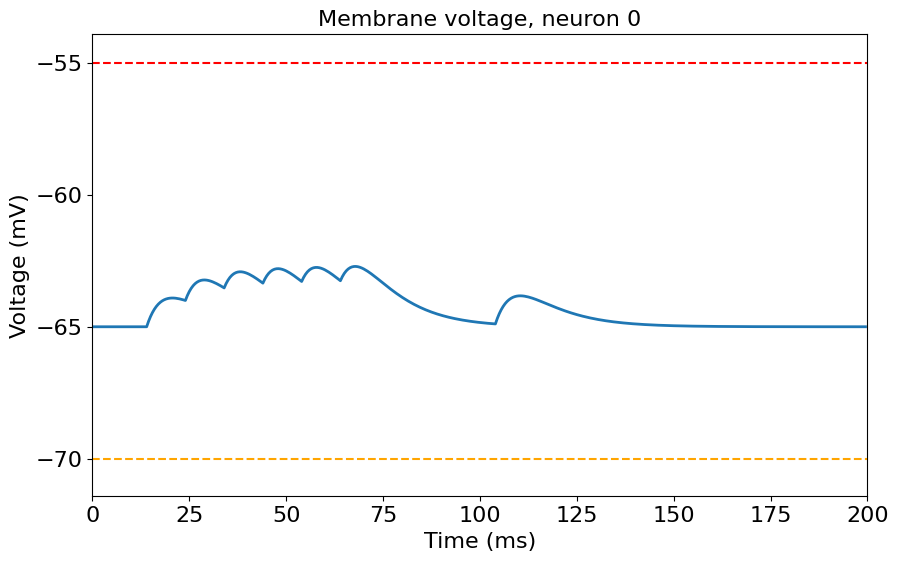

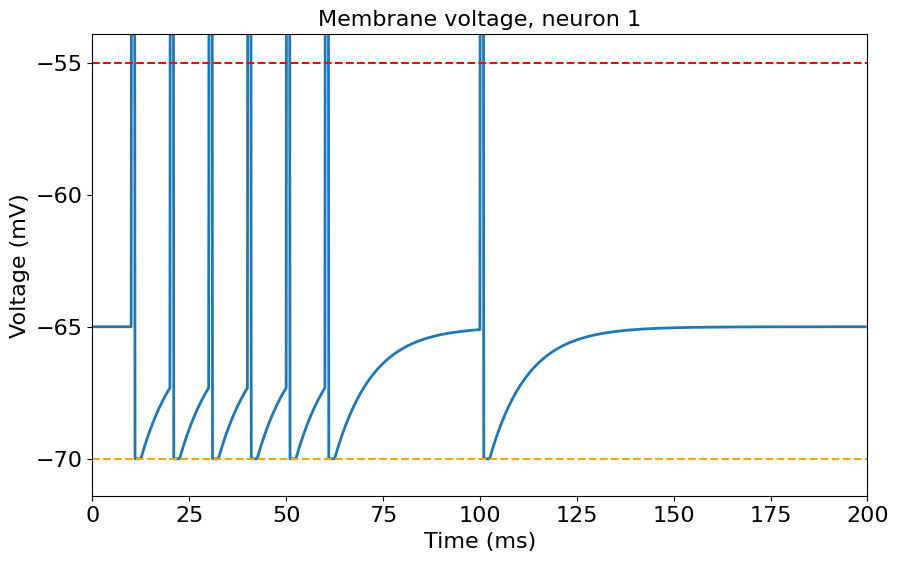

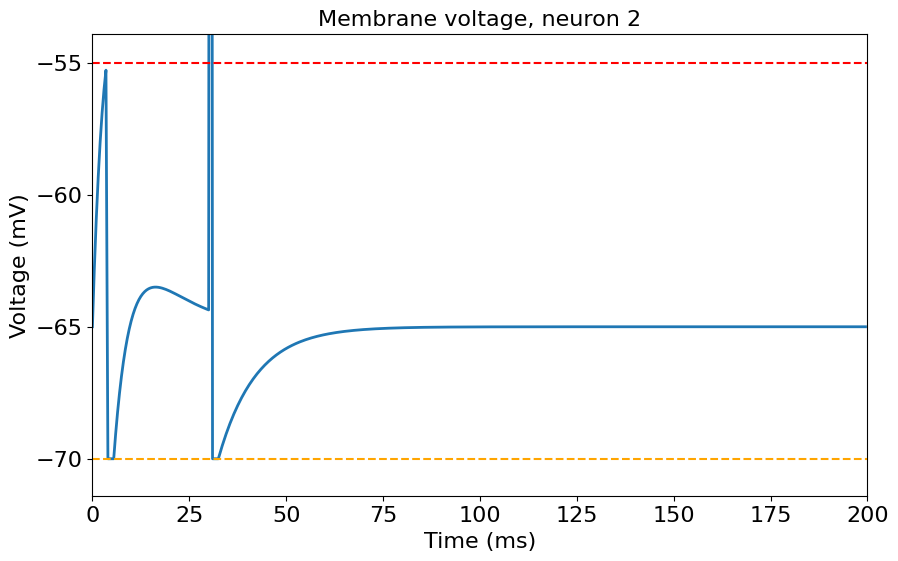

In [9]:
# Plot the time course of specific neurons `nn`
for nn in [0, 1, 2]:
    t = stm_P.t/ms
    v = stm_P.v[nn]/mV
    plt.figure(figsize=(10,6))
    plt.plot(t, v, linewidth=2)
    plt.axhline(y=v_rs/mV, color='orange', linestyle='dashed', linewidth=1.5)
    plt.axhline(y=v_th/mV, color='red', linestyle='dashed', linewidth=1.5)
    plt.title(f'Membrane voltage, neuron {nn}')
    plt.yticks(np.linspace(v_rs/mV, v_th/mV, 4))
    plt.xlim((0, t_max/ms))
    plt.ylim((1.02*v_rs/mV,0.98*v_th/mV))
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (mV)')
    plt.show()

#### Plot time course of selected synapses

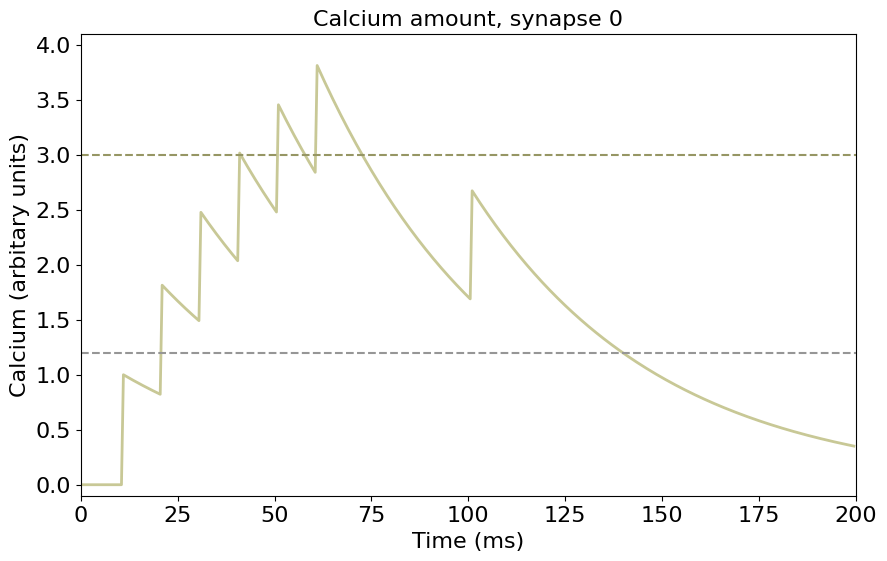

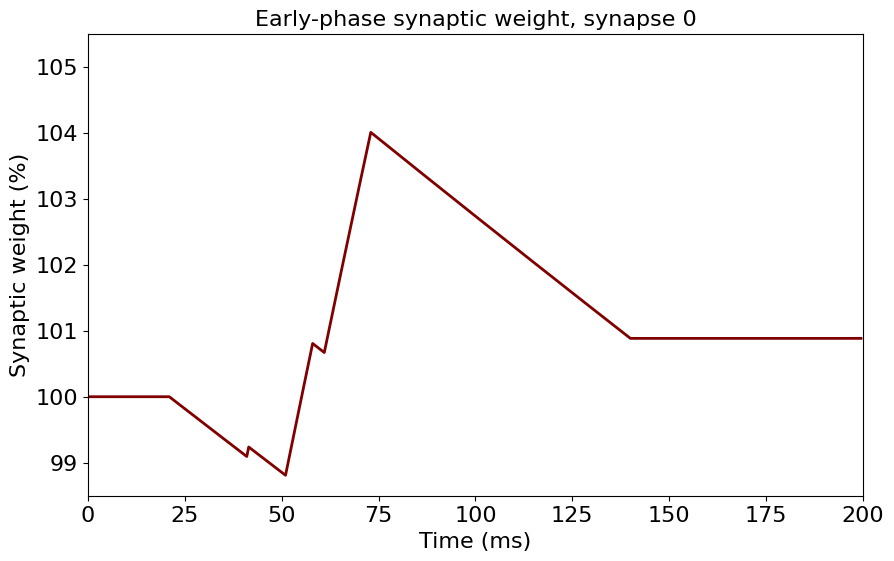

In [10]:
# Plot the time course of specific synapses `syn`
for syn in [0]:
    # Plot the time course of calcium of selected synapse `syn`
    t = stm_S_P.t/ms
    w = stm_S_P.w[syn]
    Ca = stm_S_P.Ca[syn]
    plt.figure(figsize=(10,6))
    plt.plot(t, Ca, color='#c8c896', linewidth=2)
    plt.axhline(y=theta_p, color='#969664', label=r'$\theta$_p', linestyle='dashed', linewidth=1.5)
    plt.axhline(y=theta_d, color='#969696', label=r'$\theta$_d', linestyle='dashed', linewidth=1.5)
    plt.title(f'Calcium amount, synapse {syn}')
    #plt.yticks(np.linspace(0, 2*theta_p, 5))
    plt.xlim((0, t_max/ms))
    plt.ylim((-0.10, 4.10))
    plt.xlabel('Time (ms)')
    plt.ylabel('Calcium (arbitary units)')
    plt.show()

    # Plot the time course of the early-phase weight of selected synapse `syn`
    plt.figure(figsize=(10,6))
    plt.plot(t, w/w_0*100, color="#800000", linewidth=2)
    plt.title(f'Early-phase synaptic weight, synapse {syn}')
    #plt.yticks(np.linspace(0, 200, 5))
    plt.xlim((0, t_max/ms))
    plt.ylim((98.5, 105.5))
    plt.xlabel('Time (ms)')
    plt.ylabel('Synaptic weight (%)')
    plt.show()

#### Plot spikes of all neurons

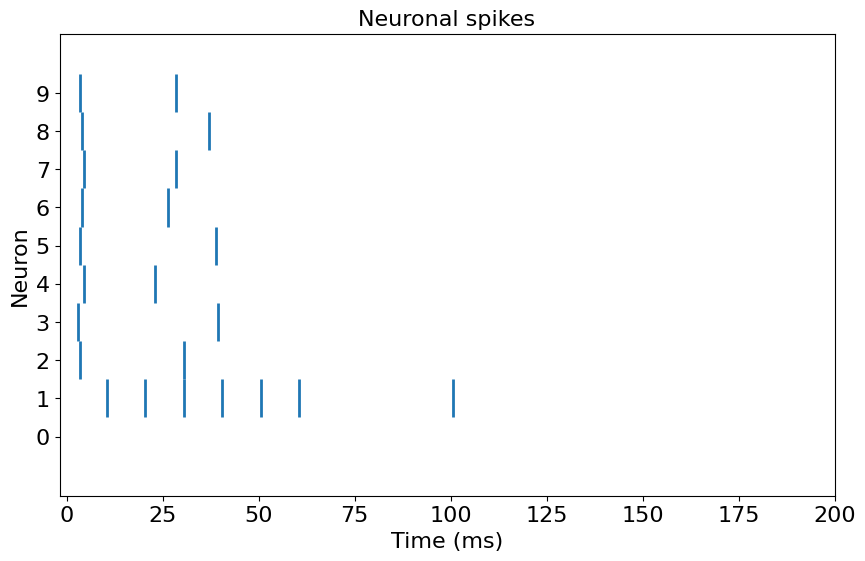

In [11]:
spike_times = [spm.t[spm.i == i]/ms for i in range(N)]

plt.figure(figsize=(10,6))
plt.eventplot(spike_times, linewidth=2)
plt.title('Neuronal spikes')
plt.xticks(np.arange(0, t_max/ms+1, t_max/ms/8))
plt.yticks(np.arange(0, N))
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')
plt.show()

#### Store data for later comparison
Comparison can be done using `*_compare.ipynb`

In [12]:
data_dir = "small_network_flexible_mode_compare"
np.save(f'{data_dir}/v_{device}.npy', np.vstack([t, stm_P.v/mV]), allow_pickle=True)
np.save(f'{data_dir}/w_{device}.npy', np.vstack([t, stm_S_P.w/w_0]), allow_pickle=True)
np.save(f'{data_dir}/Ca_{device}.npy', np.vstack([t, stm_S_P.Ca]), allow_pickle=True)
np.savez(f'{data_dir}/spikes_{device}.npz', *spike_times, allow_pickle=True)